In [1]:
import os
import torch
import time
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from torch.cuda import amp
from scipy.io import savemat
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchsummary import summary

from Network.ReActNet_18_Qaw import *
from Network.ReActNet_A_Qaw import *
from Network.utils import *

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [2]:
Begin_epoch = 0
Max_epoch = 128
Learning_rate = 1e-3
Weight_decay = 0
Momentum = 0.9
Top_k = 5
AMP = False

Dataset_path = 'tests/data/CIFAR10/'
Batch_size = 256
Workers = 8
Targetnum = 10

Test_every_iteration = None
Name_suffix = '_step2'
Savemodel_path = './savemodels/'
Record_path = './recorddata/'
if not os.path.exists(Savemodel_path):
    os.mkdir(Savemodel_path)
if not os.path.exists(Record_path):
    os.mkdir(Record_path)

In [3]:
_seed_ = 2023
torch.manual_seed(_seed_)
np.random.seed(_seed_)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
transform_train = transforms.Compose([
    transforms.Pad(4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
 
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

Train_data = datasets.CIFAR10(root=Dataset_path, train=True, download=True, transform=transform_train)
Test_data = datasets.CIFAR10(root=Dataset_path, train=False, download=True, transform=transform_test)

train_data_loader = torch.utils.data.DataLoader(
    dataset=Train_data,
    batch_size=Batch_size,
    shuffle=True,
    num_workers=Workers, 
    pin_memory=True,
    drop_last=True
)

test_data_loader = torch.utils.data.DataLoader(
    dataset=Test_data,
    batch_size=Batch_size,
    shuffle=False,
    num_workers=Workers,
    pin_memory=True,
    drop_last=False
)

In [5]:
# net = ResNet18(num_classes=Targetnum, imagenet=False)
net = Reactnet(num_classes=Targetnum, imagenet=False)

In [6]:
net = nn.DataParallel(net).cuda()
#net = net.cuda()
max_test_acc = 0.
if Begin_epoch!=0:
    net.load_state_dict(torch.load(Savemodel_path + f'epoch{Begin_epoch-1}{Name_suffix}.h5'))
    max_test_acc = np.load(Savemodel_path + f'max_acc{Name_suffix}.npy')
    max_test_acc = max_test_acc.item()
else:
    net.load_state_dict(torch.load(Savemodel_path + f'max_acc_step1.h5'))


scaler = amp.GradScaler() if AMP else None
Test_top1 = []
Test_topk = []
Test_lossall = []
Epoch_list = []
Iteration_list = []

In [7]:
criterion_train = DistributionLoss()
criterion_test = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {'params' : net.parameters(), 'weight_decay' : Weight_decay, 'initial_lr': Learning_rate}],
    lr = Learning_rate)
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda step : (1.0-step/Max_epoch), last_epoch=Begin_epoch-1)

In [8]:
def test_model(net, max_test_acc, data_loader=test_data_loader, criterion=criterion_test, epoch=None, iteration=None, record=True):
    net.eval()
    test_samples = 0
    test_loss = 0
    test_acc_top1 = 0
    test_acc_topk = 0
    
    with torch.no_grad():
        for img, label in tqdm(data_loader):
            img = img.cuda()
            label = label.cuda()
            label_onehot = F.one_hot(label, Targetnum).float()
            
            out_fr = net(img)
            loss = criterion(out_fr, label)
                
            test_samples += label.numel()
            test_loss += loss.item() * label.numel()

            test_acc_top1 += (out_fr.argmax(1) == label).float().sum().item()
            _, pred = out_fr.topk(Top_k, 1, True, True)
            test_acc_topk += torch.eq(pred, label.view(-1,1)).float().sum().item()
    
    test_loss /= test_samples
    test_acc_top1 /= test_samples
    test_acc_topk /= test_samples

    if test_acc_top1 >= max_test_acc:
        max_test_acc = test_acc_top1
        torch.save(net.state_dict(), Savemodel_path + f'max_acc{Name_suffix}.h5')
        np.save(Savemodel_path + f'max_acc{Name_suffix}.npy', np.array(max_test_acc))

    if record:
        assert epoch is not None, "epoch is None!"
        assert iteration is not None, "iteration is None!"
        
        Epoch_list.append(epoch+1)
        Iteration_list.append(iteration+1)
        Test_top1.append(test_acc_top1)
        Test_topk.append(test_acc_topk)
        Test_lossall.append(test_loss)

        record_data = np.array([Epoch_list, Iteration_list, Test_top1, Test_topk, Test_lossall]).T
        mdic = {f'Record_data':record_data, f'Record_meaning':['Epoch_list', 'Iteration_list', 'Test_top1', f'Test_top{Top_k}', 'Test_loss']}

        savemat(Record_path + f'Test_{Begin_epoch}_{epoch}{Name_suffix}.mat',mdic)
        if os.path.exists(Record_path + f'Test_{Begin_epoch}_{epoch-1}{Name_suffix}.mat'):
            os.remove(Record_path + f'Test_{Begin_epoch}_{epoch-1}{Name_suffix}.mat')

    return test_loss, test_acc_top1, test_acc_topk, max_test_acc

In [9]:
def train_model(net, max_test_acc, epoch, data_loader=train_data_loader, optimizer=optimizer, criterion=criterion_test, scaler=scaler, record=True):
    train_samples = 0
    train_loss = 0
    train_acc_top1 = 0
    train_acc_topk = 0
    
    for i, (img, label) in enumerate(tqdm(data_loader)):
        net.train()
        img = img.cuda()
        label = label.cuda()
        label_onehot = F.one_hot(label, Targetnum).float()
        
        if AMP:
            with amp.autocast():
                out_fr = net(img)
                loss = criterion(out_fr, label)
        else:
            out_fr = net(img)
            loss = criterion(out_fr, label)
            
        train_samples += label.numel()
        train_loss += loss.item() * label.numel()

        train_acc_top1 += (out_fr.argmax(1) == label).float().sum().item()
        _, pred = out_fr.topk(Top_k, 1, True, True)
        train_acc_topk += torch.eq(pred, label.view(-1,1)).float().sum().item()
        
        optimizer.zero_grad()
        if AMP:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()

            parameters_list = []
            for name, p in net.named_parameters():
                if not 'fc' in name:
                    parameters_list.append(p)
            adaptive_clip_grad(parameters_list, clip_factor=0.001)
            
            optimizer.step()

        if Test_every_iteration is not None:
            if (i+1) % Test_every_iteration == 0:
                test_loss, test_acc_top1, test_acc_topk, max_test_acc = test_model(net, max_test_acc, epoch=epoch, iteration=i, record=record)
                print(f'Test_loss: {test_loss:.4f}, Test_acc_top1: {test_acc_top1:.4f}, Test_acc_top{Top_k}: {test_acc_topk:.4f}, Max_test_acc: {max_test_acc:.4f}')
    
    train_loss /= train_samples
    train_acc_top1 /= train_samples
    train_acc_topk /= train_samples

    test_loss, test_acc_top1, test_acc_topk, max_test_acc = test_model(net, max_test_acc, epoch=epoch, iteration=i, record=record)
        
    return train_loss, train_acc_top1, train_acc_topk, test_loss, test_acc_top1, test_acc_topk, max_test_acc

In [10]:
for epoch in range(Begin_epoch, Max_epoch):

    start_time = time.time()
    train_loss, train_acc_top1, train_acc_topk, test_loss, test_acc_top1, test_acc_topk, max_test_acc = train_model(net, max_test_acc, epoch)
    
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        
    lr_scheduler.step()

    print(f'''epoch={epoch}, train_acc_top1={train_acc_top1:.4f}, train_acc_top{Top_k}={train_acc_topk:.4f}, train_loss={train_loss:.4f}, test_top1={test_acc_top1:.4f}, test_top{Top_k}={test_acc_topk:.4f}, test_loss={test_loss:.4f}, max_test_acc={max_test_acc:.4f}, total_time={(time.time() - start_time):.4f}, LR={lr:.8f}''')
    
    torch.save(net.state_dict(), Savemodel_path + f'epoch{epoch}{Name_suffix}.h5')
    if os.path.exists(Savemodel_path + f'epoch{epoch-1}{Name_suffix}.h5'):
        os.remove(Savemodel_path + f'epoch{epoch-1}{Name_suffix}.h5')

100%|██████████| 40/40 [00:03<00:00, 11.82it/s]


epoch=0, train_acc_top1=0.8782, train_acc_top5=0.9978, train_loss=0.3449, test_top1=0.8220, test_top5=0.9893, test_loss=0.5678, max_test_acc=0.8220, total_time=60.9851, LR=0.00100000


100%|██████████| 40/40 [00:03<00:00, 11.54it/s]


epoch=1, train_acc_top1=0.8771, train_acc_top5=0.9978, train_loss=0.3450, test_top1=0.8191, test_top5=0.9941, test_loss=0.5588, max_test_acc=0.8220, total_time=59.2436, LR=0.00099219


100%|██████████| 40/40 [00:03<00:00, 11.57it/s]


epoch=2, train_acc_top1=0.8798, train_acc_top5=0.9981, train_loss=0.3351, test_top1=0.8214, test_top5=0.9917, test_loss=0.5635, max_test_acc=0.8220, total_time=59.4006, LR=0.00098438


100%|██████████| 40/40 [00:03<00:00, 11.51it/s]


epoch=3, train_acc_top1=0.8820, train_acc_top5=0.9980, train_loss=0.3282, test_top1=0.8375, test_top5=0.9933, test_loss=0.5016, max_test_acc=0.8375, total_time=59.9839, LR=0.00097656


100%|██████████| 40/40 [00:03<00:00, 11.57it/s]


epoch=4, train_acc_top1=0.8838, train_acc_top5=0.9978, train_loss=0.3280, test_top1=0.8402, test_top5=0.9937, test_loss=0.5006, max_test_acc=0.8402, total_time=60.4764, LR=0.00096875


100%|██████████| 40/40 [00:03<00:00, 11.35it/s]


epoch=5, train_acc_top1=0.8891, train_acc_top5=0.9981, train_loss=0.3107, test_top1=0.8420, test_top5=0.9928, test_loss=0.4902, max_test_acc=0.8420, total_time=60.0646, LR=0.00096094


100%|██████████| 40/40 [00:03<00:00, 11.39it/s]


epoch=6, train_acc_top1=0.8897, train_acc_top5=0.9982, train_loss=0.3045, test_top1=0.8491, test_top5=0.9943, test_loss=0.4725, max_test_acc=0.8491, total_time=60.1769, LR=0.00095312


100%|██████████| 40/40 [00:03<00:00, 11.32it/s]


epoch=7, train_acc_top1=0.8982, train_acc_top5=0.9986, train_loss=0.2886, test_top1=0.8458, test_top5=0.9932, test_loss=0.4769, max_test_acc=0.8491, total_time=60.1711, LR=0.00094531


100%|██████████| 40/40 [00:03<00:00, 11.36it/s]


epoch=8, train_acc_top1=0.8999, train_acc_top5=0.9987, train_loss=0.2798, test_top1=0.8369, test_top5=0.9931, test_loss=0.5203, max_test_acc=0.8491, total_time=59.8011, LR=0.00093750


100%|██████████| 40/40 [00:03<00:00, 11.38it/s]


epoch=9, train_acc_top1=0.9024, train_acc_top5=0.9986, train_loss=0.2739, test_top1=0.8434, test_top5=0.9924, test_loss=0.4837, max_test_acc=0.8491, total_time=60.0780, LR=0.00092969


100%|██████████| 40/40 [00:03<00:00, 12.65it/s]


epoch=10, train_acc_top1=0.9077, train_acc_top5=0.9988, train_loss=0.2614, test_top1=0.8335, test_top5=0.9922, test_loss=0.5185, max_test_acc=0.8491, total_time=58.8766, LR=0.00092188


100%|██████████| 40/40 [00:03<00:00, 12.59it/s]


epoch=11, train_acc_top1=0.9082, train_acc_top5=0.9991, train_loss=0.2551, test_top1=0.8420, test_top5=0.9916, test_loss=0.5009, max_test_acc=0.8491, total_time=54.5874, LR=0.00091406


100%|██████████| 40/40 [00:03<00:00, 12.63it/s]


epoch=12, train_acc_top1=0.9135, train_acc_top5=0.9990, train_loss=0.2414, test_top1=0.8490, test_top5=0.9947, test_loss=0.4675, max_test_acc=0.8491, total_time=54.6562, LR=0.00090625


100%|██████████| 40/40 [00:03<00:00, 12.63it/s]


epoch=13, train_acc_top1=0.9173, train_acc_top5=0.9992, train_loss=0.2315, test_top1=0.8438, test_top5=0.9944, test_loss=0.4916, max_test_acc=0.8491, total_time=54.6268, LR=0.00089844


100%|██████████| 40/40 [00:03<00:00, 12.70it/s]


epoch=14, train_acc_top1=0.9155, train_acc_top5=0.9992, train_loss=0.2336, test_top1=0.8531, test_top5=0.9946, test_loss=0.4682, max_test_acc=0.8531, total_time=54.8209, LR=0.00089063


100%|██████████| 40/40 [00:03<00:00, 12.70it/s]


epoch=15, train_acc_top1=0.9240, train_acc_top5=0.9992, train_loss=0.2158, test_top1=0.8472, test_top5=0.9933, test_loss=0.4945, max_test_acc=0.8531, total_time=54.4985, LR=0.00088281


100%|██████████| 40/40 [00:03<00:00, 12.73it/s]


epoch=16, train_acc_top1=0.9238, train_acc_top5=0.9995, train_loss=0.2141, test_top1=0.8500, test_top5=0.9913, test_loss=0.4917, max_test_acc=0.8531, total_time=54.5575, LR=0.00087500


100%|██████████| 40/40 [00:03<00:00, 12.71it/s]


epoch=17, train_acc_top1=0.9252, train_acc_top5=0.9995, train_loss=0.2092, test_top1=0.8561, test_top5=0.9939, test_loss=0.4697, max_test_acc=0.8561, total_time=54.7619, LR=0.00086719


100%|██████████| 40/40 [00:03<00:00, 12.74it/s]


epoch=18, train_acc_top1=0.9263, train_acc_top5=0.9994, train_loss=0.2054, test_top1=0.8469, test_top5=0.9941, test_loss=0.4947, max_test_acc=0.8561, total_time=54.5307, LR=0.00085938


100%|██████████| 40/40 [00:03<00:00, 12.66it/s]


epoch=19, train_acc_top1=0.9312, train_acc_top5=0.9995, train_loss=0.1912, test_top1=0.8468, test_top5=0.9936, test_loss=0.4979, max_test_acc=0.8561, total_time=54.6279, LR=0.00085156


100%|██████████| 40/40 [00:03<00:00, 12.70it/s]


epoch=20, train_acc_top1=0.9333, train_acc_top5=0.9997, train_loss=0.1868, test_top1=0.8512, test_top5=0.9954, test_loss=0.4753, max_test_acc=0.8561, total_time=54.5722, LR=0.00084375


100%|██████████| 40/40 [00:03<00:00, 12.64it/s]


epoch=21, train_acc_top1=0.9352, train_acc_top5=0.9997, train_loss=0.1830, test_top1=0.8531, test_top5=0.9953, test_loss=0.4709, max_test_acc=0.8561, total_time=54.5125, LR=0.00083594


100%|██████████| 40/40 [00:03<00:00, 12.63it/s]


epoch=22, train_acc_top1=0.9362, train_acc_top5=0.9997, train_loss=0.1785, test_top1=0.8512, test_top5=0.9936, test_loss=0.4944, max_test_acc=0.8561, total_time=54.6303, LR=0.00082812


100%|██████████| 40/40 [00:03<00:00, 12.60it/s]


epoch=23, train_acc_top1=0.9388, train_acc_top5=0.9997, train_loss=0.1715, test_top1=0.8587, test_top5=0.9946, test_loss=0.4699, max_test_acc=0.8587, total_time=54.7626, LR=0.00082031


100%|██████████| 40/40 [00:03<00:00, 12.64it/s]


epoch=24, train_acc_top1=0.9412, train_acc_top5=0.9996, train_loss=0.1646, test_top1=0.8491, test_top5=0.9944, test_loss=0.4961, max_test_acc=0.8587, total_time=54.5830, LR=0.00081250


100%|██████████| 40/40 [00:03<00:00, 12.59it/s]


epoch=25, train_acc_top1=0.9423, train_acc_top5=0.9996, train_loss=0.1639, test_top1=0.8570, test_top5=0.9934, test_loss=0.4946, max_test_acc=0.8587, total_time=54.5727, LR=0.00080469


100%|██████████| 40/40 [00:03<00:00, 12.70it/s]


epoch=26, train_acc_top1=0.9448, train_acc_top5=0.9998, train_loss=0.1559, test_top1=0.8579, test_top5=0.9947, test_loss=0.4757, max_test_acc=0.8587, total_time=54.5566, LR=0.00079688


100%|██████████| 40/40 [00:03<00:00, 12.71it/s]


epoch=27, train_acc_top1=0.9458, train_acc_top5=0.9998, train_loss=0.1524, test_top1=0.8474, test_top5=0.9948, test_loss=0.5015, max_test_acc=0.8587, total_time=54.5652, LR=0.00078906


100%|██████████| 40/40 [00:03<00:00, 12.70it/s]


epoch=28, train_acc_top1=0.9477, train_acc_top5=0.9997, train_loss=0.1491, test_top1=0.8536, test_top5=0.9941, test_loss=0.4946, max_test_acc=0.8587, total_time=54.5930, LR=0.00078125


100%|██████████| 40/40 [00:03<00:00, 12.69it/s]


epoch=29, train_acc_top1=0.9478, train_acc_top5=0.9999, train_loss=0.1465, test_top1=0.8564, test_top5=0.9940, test_loss=0.4878, max_test_acc=0.8587, total_time=54.6923, LR=0.00077344


100%|██████████| 40/40 [00:03<00:00, 12.59it/s]


epoch=30, train_acc_top1=0.9487, train_acc_top5=0.9998, train_loss=0.1426, test_top1=0.8540, test_top5=0.9933, test_loss=0.4965, max_test_acc=0.8587, total_time=54.6949, LR=0.00076563


100%|██████████| 40/40 [00:03<00:00, 12.71it/s]


epoch=31, train_acc_top1=0.9521, train_acc_top5=0.9999, train_loss=0.1368, test_top1=0.8563, test_top5=0.9945, test_loss=0.5097, max_test_acc=0.8587, total_time=54.5301, LR=0.00075781


100%|██████████| 40/40 [00:03<00:00, 12.67it/s]


epoch=32, train_acc_top1=0.9524, train_acc_top5=0.9998, train_loss=0.1337, test_top1=0.8562, test_top5=0.9946, test_loss=0.4960, max_test_acc=0.8587, total_time=54.6193, LR=0.00075000


100%|██████████| 40/40 [00:03<00:00, 12.71it/s]


epoch=33, train_acc_top1=0.9545, train_acc_top5=0.9999, train_loss=0.1282, test_top1=0.8559, test_top5=0.9936, test_loss=0.5124, max_test_acc=0.8587, total_time=54.5190, LR=0.00074219


100%|██████████| 40/40 [00:03<00:00, 12.74it/s]


epoch=34, train_acc_top1=0.9562, train_acc_top5=0.9998, train_loss=0.1264, test_top1=0.8623, test_top5=0.9939, test_loss=0.4810, max_test_acc=0.8623, total_time=54.8035, LR=0.00073438


100%|██████████| 40/40 [00:03<00:00, 12.76it/s]


epoch=35, train_acc_top1=0.9588, train_acc_top5=0.9998, train_loss=0.1185, test_top1=0.8596, test_top5=0.9945, test_loss=0.5080, max_test_acc=0.8623, total_time=54.5778, LR=0.00072656


100%|██████████| 40/40 [00:03<00:00, 12.73it/s]


epoch=36, train_acc_top1=0.9595, train_acc_top5=0.9999, train_loss=0.1172, test_top1=0.8642, test_top5=0.9944, test_loss=0.4821, max_test_acc=0.8642, total_time=54.6181, LR=0.00071875


100%|██████████| 40/40 [00:03<00:00, 12.72it/s]


epoch=37, train_acc_top1=0.9604, train_acc_top5=0.9999, train_loss=0.1127, test_top1=0.8510, test_top5=0.9941, test_loss=0.5250, max_test_acc=0.8642, total_time=54.5901, LR=0.00071094


100%|██████████| 40/40 [00:03<00:00, 12.74it/s]


epoch=38, train_acc_top1=0.9616, train_acc_top5=0.9999, train_loss=0.1111, test_top1=0.8586, test_top5=0.9945, test_loss=0.4880, max_test_acc=0.8642, total_time=54.6129, LR=0.00070312


100%|██████████| 40/40 [00:03<00:00, 12.64it/s]


epoch=39, train_acc_top1=0.9616, train_acc_top5=0.9999, train_loss=0.1119, test_top1=0.8572, test_top5=0.9948, test_loss=0.5121, max_test_acc=0.8642, total_time=54.5579, LR=0.00069531


100%|██████████| 40/40 [00:03<00:00, 12.73it/s]


epoch=40, train_acc_top1=0.9633, train_acc_top5=0.9999, train_loss=0.1050, test_top1=0.8671, test_top5=0.9945, test_loss=0.4905, max_test_acc=0.8671, total_time=54.7419, LR=0.00068750


100%|██████████| 40/40 [00:03<00:00, 12.65it/s]


epoch=41, train_acc_top1=0.9635, train_acc_top5=0.9999, train_loss=0.1059, test_top1=0.8640, test_top5=0.9940, test_loss=0.4921, max_test_acc=0.8671, total_time=54.4793, LR=0.00067969


100%|██████████| 40/40 [00:03<00:00, 12.74it/s]


epoch=42, train_acc_top1=0.9642, train_acc_top5=0.9999, train_loss=0.1031, test_top1=0.8610, test_top5=0.9937, test_loss=0.4908, max_test_acc=0.8671, total_time=54.5261, LR=0.00067188


100%|██████████| 40/40 [00:03<00:00, 12.66it/s]


epoch=43, train_acc_top1=0.9666, train_acc_top5=0.9999, train_loss=0.0963, test_top1=0.8592, test_top5=0.9948, test_loss=0.5067, max_test_acc=0.8671, total_time=54.5293, LR=0.00066406


100%|██████████| 40/40 [00:03<00:00, 12.72it/s]


epoch=44, train_acc_top1=0.9685, train_acc_top5=0.9999, train_loss=0.0946, test_top1=0.8596, test_top5=0.9936, test_loss=0.4944, max_test_acc=0.8671, total_time=54.5808, LR=0.00065625


100%|██████████| 40/40 [00:03<00:00, 12.69it/s]


epoch=45, train_acc_top1=0.9677, train_acc_top5=1.0000, train_loss=0.0937, test_top1=0.8706, test_top5=0.9950, test_loss=0.4873, max_test_acc=0.8706, total_time=54.6583, LR=0.00064844


100%|██████████| 40/40 [00:03<00:00, 12.62it/s]


epoch=46, train_acc_top1=0.9674, train_acc_top5=1.0000, train_loss=0.0934, test_top1=0.8583, test_top5=0.9940, test_loss=0.5216, max_test_acc=0.8706, total_time=54.5223, LR=0.00064063


100%|██████████| 40/40 [00:03<00:00, 12.64it/s]


epoch=47, train_acc_top1=0.9694, train_acc_top5=0.9999, train_loss=0.0868, test_top1=0.8634, test_top5=0.9941, test_loss=0.5222, max_test_acc=0.8706, total_time=54.5674, LR=0.00063281


100%|██████████| 40/40 [00:03<00:00, 12.72it/s]


epoch=48, train_acc_top1=0.9697, train_acc_top5=1.0000, train_loss=0.0866, test_top1=0.8627, test_top5=0.9938, test_loss=0.5177, max_test_acc=0.8706, total_time=54.5982, LR=0.00062500


100%|██████████| 40/40 [00:03<00:00, 12.65it/s]


epoch=49, train_acc_top1=0.9709, train_acc_top5=0.9999, train_loss=0.0834, test_top1=0.8632, test_top5=0.9949, test_loss=0.5219, max_test_acc=0.8706, total_time=54.6102, LR=0.00061719


100%|██████████| 40/40 [00:03<00:00, 12.72it/s]


epoch=50, train_acc_top1=0.9717, train_acc_top5=0.9999, train_loss=0.0824, test_top1=0.8609, test_top5=0.9949, test_loss=0.5108, max_test_acc=0.8706, total_time=54.6156, LR=0.00060937


100%|██████████| 40/40 [00:03<00:00, 12.62it/s]


epoch=51, train_acc_top1=0.9714, train_acc_top5=1.0000, train_loss=0.0820, test_top1=0.8621, test_top5=0.9931, test_loss=0.5206, max_test_acc=0.8706, total_time=54.5173, LR=0.00060156


100%|██████████| 40/40 [00:03<00:00, 12.61it/s]


epoch=52, train_acc_top1=0.9724, train_acc_top5=1.0000, train_loss=0.0789, test_top1=0.8637, test_top5=0.9940, test_loss=0.5291, max_test_acc=0.8706, total_time=54.5836, LR=0.00059375


100%|██████████| 40/40 [00:03<00:00, 12.66it/s]


epoch=53, train_acc_top1=0.9739, train_acc_top5=1.0000, train_loss=0.0754, test_top1=0.8686, test_top5=0.9947, test_loss=0.5067, max_test_acc=0.8706, total_time=54.6259, LR=0.00058594


100%|██████████| 40/40 [00:03<00:00, 12.66it/s]


epoch=54, train_acc_top1=0.9747, train_acc_top5=1.0000, train_loss=0.0728, test_top1=0.8633, test_top5=0.9949, test_loss=0.5087, max_test_acc=0.8706, total_time=54.6284, LR=0.00057812


100%|██████████| 40/40 [00:03<00:00, 12.66it/s]


epoch=55, train_acc_top1=0.9764, train_acc_top5=1.0000, train_loss=0.0705, test_top1=0.8659, test_top5=0.9939, test_loss=0.5191, max_test_acc=0.8706, total_time=54.5763, LR=0.00057031


100%|██████████| 40/40 [00:03<00:00, 12.77it/s]


epoch=56, train_acc_top1=0.9764, train_acc_top5=1.0000, train_loss=0.0693, test_top1=0.8604, test_top5=0.9940, test_loss=0.5427, max_test_acc=0.8706, total_time=54.4975, LR=0.00056250


100%|██████████| 40/40 [00:03<00:00, 12.65it/s]


epoch=57, train_acc_top1=0.9757, train_acc_top5=1.0000, train_loss=0.0702, test_top1=0.8630, test_top5=0.9944, test_loss=0.5297, max_test_acc=0.8706, total_time=54.6244, LR=0.00055469


100%|██████████| 40/40 [00:03<00:00, 12.74it/s]


epoch=58, train_acc_top1=0.9779, train_acc_top5=1.0000, train_loss=0.0630, test_top1=0.8629, test_top5=0.9947, test_loss=0.5349, max_test_acc=0.8706, total_time=54.6008, LR=0.00054688


100%|██████████| 40/40 [00:03<00:00, 12.61it/s]


epoch=59, train_acc_top1=0.9781, train_acc_top5=1.0000, train_loss=0.0653, test_top1=0.8639, test_top5=0.9942, test_loss=0.5518, max_test_acc=0.8706, total_time=54.5923, LR=0.00053906


100%|██████████| 40/40 [00:03<00:00, 12.72it/s]


epoch=60, train_acc_top1=0.9783, train_acc_top5=0.9999, train_loss=0.0617, test_top1=0.8610, test_top5=0.9941, test_loss=0.5269, max_test_acc=0.8706, total_time=54.5603, LR=0.00053125


100%|██████████| 40/40 [00:03<00:00, 12.61it/s]


epoch=61, train_acc_top1=0.9796, train_acc_top5=1.0000, train_loss=0.0615, test_top1=0.8669, test_top5=0.9929, test_loss=0.5184, max_test_acc=0.8706, total_time=54.5980, LR=0.00052344


100%|██████████| 40/40 [00:03<00:00, 12.74it/s]


epoch=62, train_acc_top1=0.9803, train_acc_top5=1.0000, train_loss=0.0589, test_top1=0.8662, test_top5=0.9927, test_loss=0.5331, max_test_acc=0.8706, total_time=54.5445, LR=0.00051563


100%|██████████| 40/40 [00:03<00:00, 12.75it/s]


epoch=63, train_acc_top1=0.9808, train_acc_top5=1.0000, train_loss=0.0575, test_top1=0.8656, test_top5=0.9936, test_loss=0.5289, max_test_acc=0.8706, total_time=54.5359, LR=0.00050781


100%|██████████| 40/40 [00:03<00:00, 12.75it/s]


epoch=64, train_acc_top1=0.9802, train_acc_top5=1.0000, train_loss=0.0574, test_top1=0.8683, test_top5=0.9943, test_loss=0.5253, max_test_acc=0.8706, total_time=54.6122, LR=0.00050000


100%|██████████| 40/40 [00:03<00:00, 12.67it/s]


epoch=65, train_acc_top1=0.9815, train_acc_top5=1.0000, train_loss=0.0556, test_top1=0.8668, test_top5=0.9942, test_loss=0.5481, max_test_acc=0.8706, total_time=54.5129, LR=0.00049219


100%|██████████| 40/40 [00:03<00:00, 12.73it/s]


epoch=66, train_acc_top1=0.9823, train_acc_top5=1.0000, train_loss=0.0529, test_top1=0.8659, test_top5=0.9945, test_loss=0.5367, max_test_acc=0.8706, total_time=54.4802, LR=0.00048437


100%|██████████| 40/40 [00:03<00:00, 12.75it/s]


epoch=67, train_acc_top1=0.9809, train_acc_top5=1.0000, train_loss=0.0566, test_top1=0.8688, test_top5=0.9955, test_loss=0.5222, max_test_acc=0.8706, total_time=54.5310, LR=0.00047656


100%|██████████| 40/40 [00:03<00:00, 12.73it/s]


epoch=68, train_acc_top1=0.9828, train_acc_top5=1.0000, train_loss=0.0510, test_top1=0.8678, test_top5=0.9945, test_loss=0.5256, max_test_acc=0.8706, total_time=54.5494, LR=0.00046875


100%|██████████| 40/40 [00:03<00:00, 12.63it/s]


epoch=69, train_acc_top1=0.9821, train_acc_top5=1.0000, train_loss=0.0521, test_top1=0.8654, test_top5=0.9939, test_loss=0.5606, max_test_acc=0.8706, total_time=54.6408, LR=0.00046094


100%|██████████| 40/40 [00:03<00:00, 12.70it/s]


epoch=70, train_acc_top1=0.9839, train_acc_top5=1.0000, train_loss=0.0481, test_top1=0.8669, test_top5=0.9934, test_loss=0.5448, max_test_acc=0.8706, total_time=54.6282, LR=0.00045313


100%|██████████| 40/40 [00:03<00:00, 12.64it/s]


epoch=71, train_acc_top1=0.9838, train_acc_top5=1.0000, train_loss=0.0477, test_top1=0.8711, test_top5=0.9948, test_loss=0.5279, max_test_acc=0.8711, total_time=54.7155, LR=0.00044531


100%|██████████| 40/40 [00:03<00:00, 12.63it/s]


epoch=72, train_acc_top1=0.9848, train_acc_top5=1.0000, train_loss=0.0465, test_top1=0.8696, test_top5=0.9941, test_loss=0.5359, max_test_acc=0.8711, total_time=54.5733, LR=0.00043750


100%|██████████| 40/40 [00:03<00:00, 12.64it/s]


epoch=73, train_acc_top1=0.9848, train_acc_top5=1.0000, train_loss=0.0461, test_top1=0.8721, test_top5=0.9943, test_loss=0.5319, max_test_acc=0.8721, total_time=54.7885, LR=0.00042969


100%|██████████| 40/40 [00:03<00:00, 12.61it/s]


epoch=74, train_acc_top1=0.9856, train_acc_top5=1.0000, train_loss=0.0435, test_top1=0.8660, test_top5=0.9953, test_loss=0.5572, max_test_acc=0.8721, total_time=54.6709, LR=0.00042187


100%|██████████| 40/40 [00:03<00:00, 12.61it/s]


epoch=75, train_acc_top1=0.9854, train_acc_top5=1.0000, train_loss=0.0454, test_top1=0.8665, test_top5=0.9940, test_loss=0.5561, max_test_acc=0.8721, total_time=54.6874, LR=0.00041406


100%|██████████| 40/40 [00:03<00:00, 12.65it/s]


epoch=76, train_acc_top1=0.9864, train_acc_top5=1.0000, train_loss=0.0420, test_top1=0.8707, test_top5=0.9948, test_loss=0.5438, max_test_acc=0.8721, total_time=54.5819, LR=0.00040625


100%|██████████| 40/40 [00:03<00:00, 12.72it/s]


epoch=77, train_acc_top1=0.9865, train_acc_top5=1.0000, train_loss=0.0403, test_top1=0.8738, test_top5=0.9941, test_loss=0.5361, max_test_acc=0.8738, total_time=54.8121, LR=0.00039844


100%|██████████| 40/40 [00:03<00:00, 12.71it/s]


epoch=78, train_acc_top1=0.9874, train_acc_top5=1.0000, train_loss=0.0390, test_top1=0.8736, test_top5=0.9953, test_loss=0.5353, max_test_acc=0.8738, total_time=54.5476, LR=0.00039063


100%|██████████| 40/40 [00:03<00:00, 12.62it/s]


epoch=79, train_acc_top1=0.9883, train_acc_top5=1.0000, train_loss=0.0373, test_top1=0.8721, test_top5=0.9945, test_loss=0.5435, max_test_acc=0.8738, total_time=54.6291, LR=0.00038281


100%|██████████| 40/40 [00:03<00:00, 12.72it/s]


epoch=80, train_acc_top1=0.9876, train_acc_top5=1.0000, train_loss=0.0378, test_top1=0.8678, test_top5=0.9952, test_loss=0.5623, max_test_acc=0.8738, total_time=54.5960, LR=0.00037500


100%|██████████| 40/40 [00:03<00:00, 12.65it/s]


epoch=81, train_acc_top1=0.9889, train_acc_top5=1.0000, train_loss=0.0359, test_top1=0.8708, test_top5=0.9950, test_loss=0.5368, max_test_acc=0.8738, total_time=54.5692, LR=0.00036719


100%|██████████| 40/40 [00:03<00:00, 12.59it/s]


epoch=82, train_acc_top1=0.9891, train_acc_top5=1.0000, train_loss=0.0343, test_top1=0.8733, test_top5=0.9938, test_loss=0.5445, max_test_acc=0.8738, total_time=54.6158, LR=0.00035937


100%|██████████| 40/40 [00:03<00:00, 12.70it/s]


epoch=83, train_acc_top1=0.9898, train_acc_top5=1.0000, train_loss=0.0335, test_top1=0.8693, test_top5=0.9948, test_loss=0.5520, max_test_acc=0.8738, total_time=54.5451, LR=0.00035156


100%|██████████| 40/40 [00:03<00:00, 12.71it/s]


epoch=84, train_acc_top1=0.9905, train_acc_top5=1.0000, train_loss=0.0307, test_top1=0.8699, test_top5=0.9941, test_loss=0.5549, max_test_acc=0.8738, total_time=54.5988, LR=0.00034375


100%|██████████| 40/40 [00:03<00:00, 12.73it/s]


epoch=85, train_acc_top1=0.9899, train_acc_top5=1.0000, train_loss=0.0315, test_top1=0.8739, test_top5=0.9943, test_loss=0.5446, max_test_acc=0.8739, total_time=54.7700, LR=0.00033594


100%|██████████| 40/40 [00:03<00:00, 12.63it/s]


epoch=86, train_acc_top1=0.9898, train_acc_top5=1.0000, train_loss=0.0316, test_top1=0.8736, test_top5=0.9944, test_loss=0.5414, max_test_acc=0.8739, total_time=54.5533, LR=0.00032813


100%|██████████| 40/40 [00:03<00:00, 12.71it/s]


epoch=87, train_acc_top1=0.9909, train_acc_top5=1.0000, train_loss=0.0298, test_top1=0.8692, test_top5=0.9942, test_loss=0.5418, max_test_acc=0.8739, total_time=54.5245, LR=0.00032031


100%|██████████| 40/40 [00:03<00:00, 12.72it/s]


epoch=88, train_acc_top1=0.9895, train_acc_top5=1.0000, train_loss=0.0324, test_top1=0.8716, test_top5=0.9944, test_loss=0.5525, max_test_acc=0.8739, total_time=54.6711, LR=0.00031250


100%|██████████| 40/40 [00:03<00:00, 12.69it/s]


epoch=89, train_acc_top1=0.9909, train_acc_top5=1.0000, train_loss=0.0293, test_top1=0.8690, test_top5=0.9945, test_loss=0.5559, max_test_acc=0.8739, total_time=54.6208, LR=0.00030469


100%|██████████| 40/40 [00:03<00:00, 12.65it/s]


epoch=90, train_acc_top1=0.9916, train_acc_top5=1.0000, train_loss=0.0271, test_top1=0.8727, test_top5=0.9947, test_loss=0.5519, max_test_acc=0.8739, total_time=54.6295, LR=0.00029687


100%|██████████| 40/40 [00:03<00:00, 12.70it/s]


epoch=91, train_acc_top1=0.9920, train_acc_top5=1.0000, train_loss=0.0267, test_top1=0.8728, test_top5=0.9940, test_loss=0.5451, max_test_acc=0.8739, total_time=54.5707, LR=0.00028906


100%|██████████| 40/40 [00:03<00:00, 12.73it/s]


epoch=92, train_acc_top1=0.9921, train_acc_top5=1.0000, train_loss=0.0264, test_top1=0.8712, test_top5=0.9943, test_loss=0.5635, max_test_acc=0.8739, total_time=54.6536, LR=0.00028125


100%|██████████| 40/40 [00:03<00:00, 12.71it/s]


epoch=93, train_acc_top1=0.9908, train_acc_top5=1.0000, train_loss=0.0278, test_top1=0.8745, test_top5=0.9939, test_loss=0.5544, max_test_acc=0.8745, total_time=54.8322, LR=0.00027344


100%|██████████| 40/40 [00:03<00:00, 12.70it/s]


epoch=94, train_acc_top1=0.9921, train_acc_top5=1.0000, train_loss=0.0256, test_top1=0.8728, test_top5=0.9950, test_loss=0.5640, max_test_acc=0.8745, total_time=54.6499, LR=0.00026563


100%|██████████| 40/40 [00:03<00:00, 12.62it/s]


epoch=95, train_acc_top1=0.9926, train_acc_top5=1.0000, train_loss=0.0243, test_top1=0.8709, test_top5=0.9947, test_loss=0.5688, max_test_acc=0.8745, total_time=54.6147, LR=0.00025781


100%|██████████| 40/40 [00:03<00:00, 12.64it/s]


epoch=96, train_acc_top1=0.9931, train_acc_top5=1.0000, train_loss=0.0227, test_top1=0.8729, test_top5=0.9951, test_loss=0.5518, max_test_acc=0.8745, total_time=54.6358, LR=0.00025000


100%|██████████| 40/40 [00:03<00:00, 12.71it/s]


epoch=97, train_acc_top1=0.9935, train_acc_top5=1.0000, train_loss=0.0221, test_top1=0.8769, test_top5=0.9942, test_loss=0.5529, max_test_acc=0.8769, total_time=54.7869, LR=0.00024219


100%|██████████| 40/40 [00:03<00:00, 12.63it/s]


epoch=98, train_acc_top1=0.9934, train_acc_top5=1.0000, train_loss=0.0217, test_top1=0.8742, test_top5=0.9941, test_loss=0.5659, max_test_acc=0.8769, total_time=54.6566, LR=0.00023437


100%|██████████| 40/40 [00:03<00:00, 12.71it/s]


epoch=99, train_acc_top1=0.9938, train_acc_top5=1.0000, train_loss=0.0212, test_top1=0.8753, test_top5=0.9940, test_loss=0.5630, max_test_acc=0.8769, total_time=54.5491, LR=0.00022656


100%|██████████| 40/40 [00:03<00:00, 12.70it/s]


epoch=100, train_acc_top1=0.9927, train_acc_top5=1.0000, train_loss=0.0218, test_top1=0.8732, test_top5=0.9937, test_loss=0.5789, max_test_acc=0.8769, total_time=54.6147, LR=0.00021875


100%|██████████| 40/40 [00:03<00:00, 12.59it/s]


epoch=101, train_acc_top1=0.9945, train_acc_top5=1.0000, train_loss=0.0194, test_top1=0.8714, test_top5=0.9947, test_loss=0.5761, max_test_acc=0.8769, total_time=54.7172, LR=0.00021094


100%|██████████| 40/40 [00:03<00:00, 12.72it/s]


epoch=102, train_acc_top1=0.9944, train_acc_top5=1.0000, train_loss=0.0192, test_top1=0.8767, test_top5=0.9940, test_loss=0.5575, max_test_acc=0.8769, total_time=54.6618, LR=0.00020313


100%|██████████| 40/40 [00:03<00:00, 12.63it/s]


epoch=103, train_acc_top1=0.9941, train_acc_top5=1.0000, train_loss=0.0191, test_top1=0.8732, test_top5=0.9949, test_loss=0.5732, max_test_acc=0.8769, total_time=54.6171, LR=0.00019531


100%|██████████| 40/40 [00:03<00:00, 12.66it/s]


epoch=104, train_acc_top1=0.9946, train_acc_top5=1.0000, train_loss=0.0186, test_top1=0.8722, test_top5=0.9951, test_loss=0.5735, max_test_acc=0.8769, total_time=54.6270, LR=0.00018750


100%|██████████| 40/40 [00:03<00:00, 12.64it/s]


epoch=105, train_acc_top1=0.9952, train_acc_top5=1.0000, train_loss=0.0171, test_top1=0.8770, test_top5=0.9953, test_loss=0.5578, max_test_acc=0.8770, total_time=54.7857, LR=0.00017969


100%|██████████| 40/40 [00:03<00:00, 12.72it/s]


epoch=106, train_acc_top1=0.9949, train_acc_top5=1.0000, train_loss=0.0174, test_top1=0.8793, test_top5=0.9947, test_loss=0.5611, max_test_acc=0.8793, total_time=54.8012, LR=0.00017187


100%|██████████| 40/40 [00:03<00:00, 12.69it/s]


epoch=107, train_acc_top1=0.9959, train_acc_top5=1.0000, train_loss=0.0149, test_top1=0.8734, test_top5=0.9953, test_loss=0.5752, max_test_acc=0.8793, total_time=54.6482, LR=0.00016406


100%|██████████| 40/40 [00:03<00:00, 12.62it/s]


epoch=108, train_acc_top1=0.9953, train_acc_top5=1.0000, train_loss=0.0162, test_top1=0.8765, test_top5=0.9939, test_loss=0.5608, max_test_acc=0.8793, total_time=54.6538, LR=0.00015625


100%|██████████| 40/40 [00:03<00:00, 12.72it/s]


epoch=109, train_acc_top1=0.9961, train_acc_top5=1.0000, train_loss=0.0142, test_top1=0.8751, test_top5=0.9949, test_loss=0.5667, max_test_acc=0.8793, total_time=54.5383, LR=0.00014844


100%|██████████| 40/40 [00:03<00:00, 12.59it/s]


epoch=110, train_acc_top1=0.9961, train_acc_top5=1.0000, train_loss=0.0143, test_top1=0.8767, test_top5=0.9951, test_loss=0.5617, max_test_acc=0.8793, total_time=54.6709, LR=0.00014063


100%|██████████| 40/40 [00:03<00:00, 12.58it/s]


epoch=111, train_acc_top1=0.9961, train_acc_top5=1.0000, train_loss=0.0143, test_top1=0.8767, test_top5=0.9949, test_loss=0.5692, max_test_acc=0.8793, total_time=54.6705, LR=0.00013281


100%|██████████| 40/40 [00:03<00:00, 12.57it/s]


epoch=112, train_acc_top1=0.9963, train_acc_top5=1.0000, train_loss=0.0137, test_top1=0.8755, test_top5=0.9952, test_loss=0.5694, max_test_acc=0.8793, total_time=54.5990, LR=0.00012500


100%|██████████| 40/40 [00:03<00:00, 12.60it/s]


epoch=113, train_acc_top1=0.9967, train_acc_top5=1.0000, train_loss=0.0128, test_top1=0.8753, test_top5=0.9943, test_loss=0.5841, max_test_acc=0.8793, total_time=54.5957, LR=0.00011719


100%|██████████| 40/40 [00:03<00:00, 12.70it/s]


epoch=114, train_acc_top1=0.9969, train_acc_top5=1.0000, train_loss=0.0122, test_top1=0.8761, test_top5=0.9949, test_loss=0.5765, max_test_acc=0.8793, total_time=54.6785, LR=0.00010938


100%|██████████| 40/40 [00:03<00:00, 11.57it/s]


epoch=115, train_acc_top1=0.9966, train_acc_top5=1.0000, train_loss=0.0125, test_top1=0.8780, test_top5=0.9948, test_loss=0.5754, max_test_acc=0.8793, total_time=56.9643, LR=0.00010156


100%|██████████| 40/40 [00:03<00:00, 11.59it/s]


epoch=116, train_acc_top1=0.9971, train_acc_top5=1.0000, train_loss=0.0113, test_top1=0.8790, test_top5=0.9953, test_loss=0.5603, max_test_acc=0.8793, total_time=60.3257, LR=0.00009375


100%|██████████| 40/40 [00:03<00:00, 11.50it/s]


epoch=117, train_acc_top1=0.9975, train_acc_top5=1.0000, train_loss=0.0102, test_top1=0.8818, test_top5=0.9955, test_loss=0.5645, max_test_acc=0.8818, total_time=60.1726, LR=0.00008594


100%|██████████| 40/40 [00:03<00:00, 11.79it/s]


epoch=118, train_acc_top1=0.9973, train_acc_top5=1.0000, train_loss=0.0112, test_top1=0.8782, test_top5=0.9955, test_loss=0.5623, max_test_acc=0.8818, total_time=60.0666, LR=0.00007813


100%|██████████| 40/40 [00:03<00:00, 11.73it/s]


epoch=119, train_acc_top1=0.9971, train_acc_top5=1.0000, train_loss=0.0106, test_top1=0.8775, test_top5=0.9951, test_loss=0.5609, max_test_acc=0.8818, total_time=60.2975, LR=0.00007031


100%|██████████| 40/40 [00:03<00:00, 11.74it/s]


epoch=120, train_acc_top1=0.9977, train_acc_top5=1.0000, train_loss=0.0095, test_top1=0.8810, test_top5=0.9951, test_loss=0.5698, max_test_acc=0.8818, total_time=59.8960, LR=0.00006250


100%|██████████| 40/40 [00:03<00:00, 11.72it/s]


epoch=121, train_acc_top1=0.9977, train_acc_top5=1.0000, train_loss=0.0098, test_top1=0.8792, test_top5=0.9949, test_loss=0.5599, max_test_acc=0.8818, total_time=60.2266, LR=0.00005469


100%|██████████| 40/40 [00:03<00:00, 11.68it/s]


epoch=122, train_acc_top1=0.9980, train_acc_top5=1.0000, train_loss=0.0087, test_top1=0.8813, test_top5=0.9954, test_loss=0.5652, max_test_acc=0.8818, total_time=60.5194, LR=0.00004688


100%|██████████| 40/40 [00:03<00:00, 11.52it/s]


epoch=123, train_acc_top1=0.9980, train_acc_top5=1.0000, train_loss=0.0089, test_top1=0.8782, test_top5=0.9953, test_loss=0.5568, max_test_acc=0.8818, total_time=60.0698, LR=0.00003906


100%|██████████| 40/40 [00:03<00:00, 11.77it/s]


epoch=124, train_acc_top1=0.9982, train_acc_top5=1.0000, train_loss=0.0082, test_top1=0.8801, test_top5=0.9952, test_loss=0.5637, max_test_acc=0.8818, total_time=61.9565, LR=0.00003125


100%|██████████| 40/40 [00:03<00:00, 11.55it/s]


epoch=125, train_acc_top1=0.9982, train_acc_top5=1.0000, train_loss=0.0083, test_top1=0.8790, test_top5=0.9953, test_loss=0.5506, max_test_acc=0.8818, total_time=60.1241, LR=0.00002344


100%|██████████| 40/40 [00:03<00:00, 11.86it/s]


epoch=126, train_acc_top1=0.9983, train_acc_top5=1.0000, train_loss=0.0079, test_top1=0.8827, test_top5=0.9955, test_loss=0.5640, max_test_acc=0.8827, total_time=59.5700, LR=0.00001563


100%|██████████| 40/40 [00:03<00:00, 11.90it/s]

epoch=127, train_acc_top1=0.9982, train_acc_top5=1.0000, train_loss=0.0081, test_top1=0.8803, test_top5=0.9946, test_loss=0.5638, max_test_acc=0.8827, total_time=59.9487, LR=0.00000781


In [11]:
net.load_state_dict(torch.load(Savemodel_path + f'max_acc{Name_suffix}.h5'))

<All keys matched successfully>

In [12]:
Confusion_Matrix = torch.zeros((Targetnum, Targetnum))
net.eval()
with torch.no_grad():
    for img, label in tqdm(test_data_loader):
        img = img.cuda()
        label = label.cuda()
        out_fr = net(img)
        guess = out_fr.argmax(1)
        for j in range(len(label)):
            Confusion_Matrix[label[j],guess[j]] += 1
acc = Confusion_Matrix.diag()
acc = acc.sum()/Confusion_Matrix.sum()
print(f'Confusion_Matrix = {Confusion_Matrix}')
print(f'acc = {acc}')

100%|██████████| 40/40 [00:04<00:00,  9.75it/s]

Confusion_Matrix = tensor([[917.,  10.,  23.,   4.,   4.,   2.,   4.,   4.,  24.,   8.],
        [  8., 943.,   2.,   1.,   0.,   0.,   2.,   1.,   6.,  37.],
        [ 36.,   0., 827.,  39.,  39.,  11.,  33.,  10.,   3.,   2.],
        [ 11.,   2.,  42., 764.,  32.,  94.,  28.,  12.,   6.,   9.],
        [ 10.,   2.,  38.,  28., 867.,   8.,  28.,  15.,   3.,   1.],
        [  5.,   0.,  13., 102.,  26., 817.,  12.,  22.,   1.,   2.],
        [  7.,   0.,  16.,  24.,  14.,   8., 925.,   2.,   2.,   2.],
        [  8.,   0.,  15.,  26.,  23.,  23.,   4., 893.,   1.,   7.],
        [ 28.,   8.,   2.,   3.,   1.,   4.,   2.,   0., 940.,  12.],
        [ 12.,  36.,   0.,   4.,   1.,   0.,   5.,   1.,   7., 934.]])
acc = 0.8827000260353088


Fichier chargé: ./recorddata/Test_0_127_step2.mat


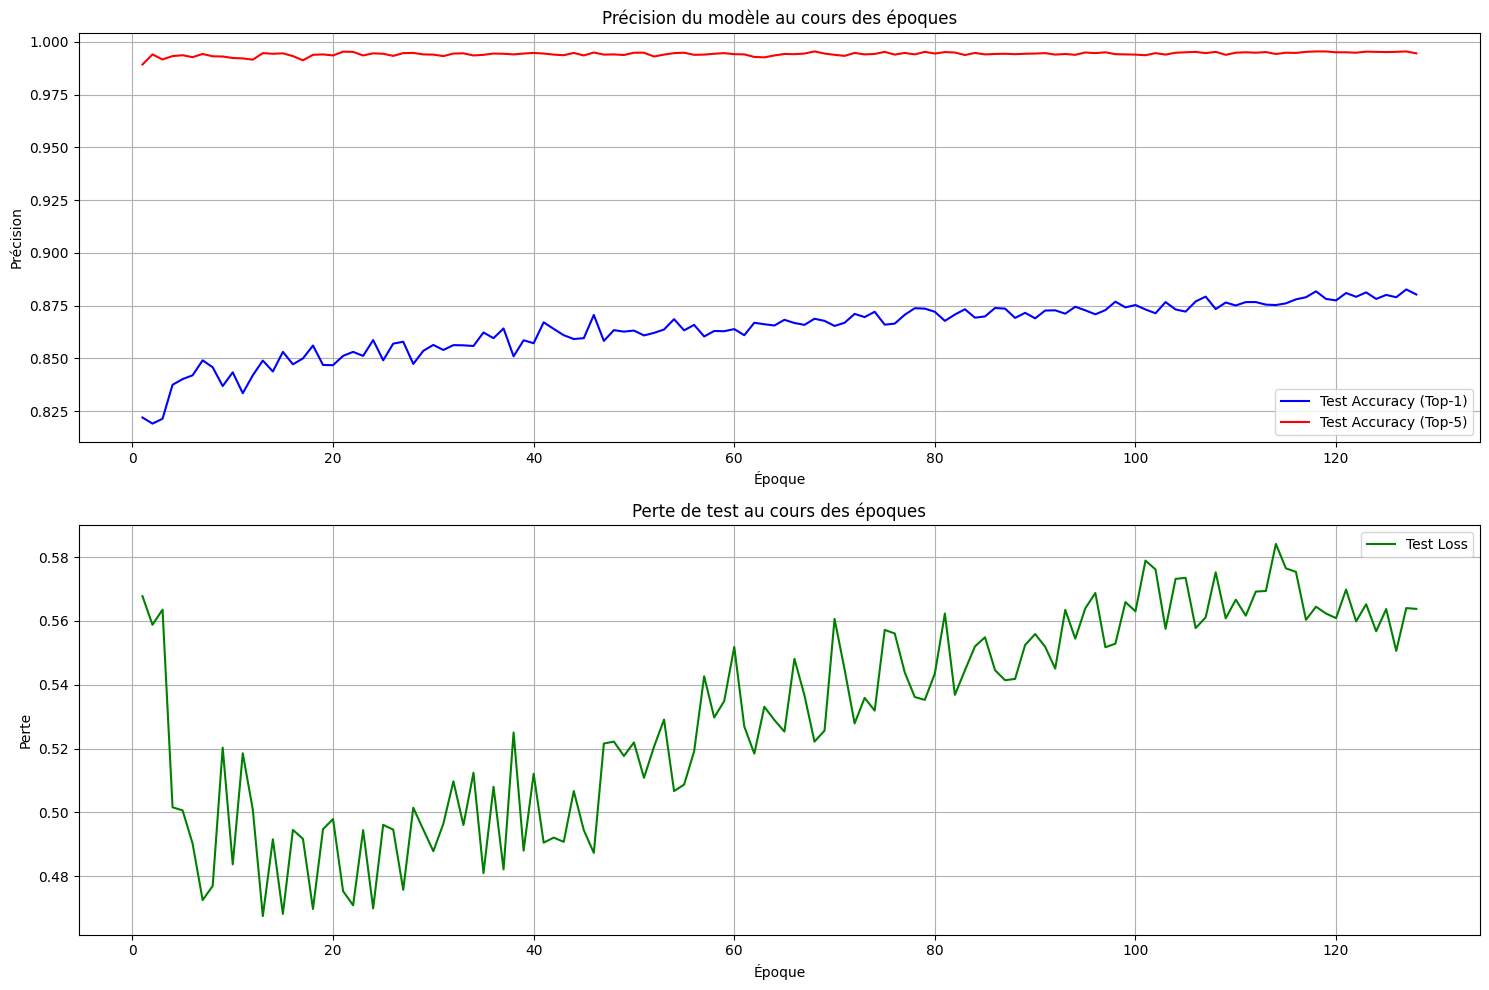

Meilleure précision: 0.8827 à l'époque 127.0
Fichier log ./training_log.txt non trouvé. Essayez de rediriger la sortie du script d'entraînement vers un fichier.
Exemple: python train_script.py > training_log.txt


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os
import glob

def plot_learning_curves(record_path, name_suffix="_step2", top_k=5):
    """
    Visualise les courbes d'apprentissage à partir des fichiers .mat générés
    """
    # Recherche du fichier le plus récent
    pattern = os.path.join(record_path, f'Test_*{name_suffix}.mat')
    files = glob.glob(pattern)
    
    if not files:
        print(f"Aucun fichier trouvé avec le pattern: {pattern}")
        return
    
    # Charger le fichier le plus récent
    latest_file = max(files, key=os.path.getctime)
    print(f"Fichier chargé: {latest_file}")
    
    data = loadmat(latest_file)
    record_data = data['Record_data']
    
    # Extraire les données
    epochs = record_data[:, 0]
    test_top1 = record_data[:, 2]
    test_topk = record_data[:, 3]
    test_loss = record_data[:, 4]
    
    # Créer les graphiques
    plt.figure(figsize=(15, 10))
    
    # Précision Top-1 et Top-k
    plt.subplot(2, 1, 1)
    plt.plot(epochs, test_top1, 'b-', label=f'Test Accuracy (Top-1)')
    plt.plot(epochs, test_topk, 'r-', label=f'Test Accuracy (Top-{top_k})')
    plt.title('Précision du modèle au cours des époques')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.grid(True)
    plt.legend()
    
    # Perte de test
    plt.subplot(2, 1, 2)
    plt.plot(epochs, test_loss, 'g-', label='Test Loss')
    plt.title('Perte de test au cours des époques')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(record_path, f'learning_curves{name_suffix}.png'))
    plt.show()
    
    return max(test_top1), epochs[np.argmax(test_top1)]

def extract_training_history(log_file_path):
    """
    Extraire l'historique d'entraînement à partir d'un fichier log
    """
    epochs = []
    train_acc_top1 = []
    train_acc_topk = []
    train_losses = []
    test_acc_top1 = []
    test_acc_topk = []
    test_losses = []
    max_test_accs = []
    learning_rates = []
    
    with open(log_file_path, 'r') as f:
        for line in f:
            if line.startswith('epoch='):
                parts = line.strip().split(',')
                
                # Extraire l'époque
                epoch = int(parts[0].split('=')[1])
                epochs.append(epoch)
                
                # Extraire les métriques d'entraînement
                for part in parts:
                    part = part.strip()
                    if 'train_acc_top1=' in part:
                        train_acc_top1.append(float(part.split('=')[1]))
                    elif 'train_acc_top5=' in part:
                        train_acc_topk.append(float(part.split('=')[1]))
                    elif 'train_loss=' in part:
                        train_losses.append(float(part.split('=')[1]))
                    elif 'test_top1=' in part:
                        test_acc_top1.append(float(part.split('=')[1]))
                    elif 'test_top5=' in part:
                        test_acc_topk.append(float(part.split('=')[1]))
                    elif 'test_loss=' in part:
                        test_losses.append(float(part.split('=')[1]))
                    elif 'max_test_acc=' in part:
                        max_test_accs.append(float(part.split('=')[1]))
                    elif 'LR=' in part:
                        learning_rates.append(float(part.split('=')[1]))
    
    return {
        'epochs': epochs,
        'train_acc_top1': train_acc_top1,
        'train_acc_topk': train_acc_topk,
        'train_losses': train_losses,
        'test_acc_top1': test_acc_top1,
        'test_acc_topk': test_acc_topk,
        'test_losses': test_losses,
        'max_test_accs': max_test_accs,
        'learning_rates': learning_rates
    }

def plot_train_test_comparison(history, top_k=5, save_path=None):
    """
    Compare les métriques d'entraînement et de test
    """
    epochs = history['epochs']
    
    plt.figure(figsize=(15, 15))
    
    # Précision Top-1
    plt.subplot(3, 1, 1)
    plt.plot(epochs, history['train_acc_top1'], 'b-', label='Train Accuracy (Top-1)')
    plt.plot(epochs, history['test_acc_top1'], 'r-', label='Test Accuracy (Top-1)')
    plt.title('Précision Top-1 (Train vs Test)')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.grid(True)
    plt.legend()
    
    # Précision Top-k
    plt.subplot(3, 1, 2)
    plt.plot(epochs, history['train_acc_topk'], 'b-', label=f'Train Accuracy (Top-{top_k})')
    plt.plot(epochs, history['test_acc_topk'], 'r-', label=f'Test Accuracy (Top-{top_k})')
    plt.title(f'Précision Top-{top_k} (Train vs Test)')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.grid(True)
    plt.legend()
    
    # Perte
    plt.subplot(3, 1, 3)
    plt.plot(epochs, history['train_losses'], 'b-', label='Train Loss')
    plt.plot(epochs, history['test_losses'], 'r-', label='Test Loss')
    plt.title('Perte (Train vs Test)')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

def plot_learning_rate(history, save_path=None):
    """
    Visualise l'évolution du taux d'apprentissage
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history['epochs'], history['learning_rates'], 'b-')
    plt.title("Évolution du taux d'apprentissag")
    plt.xlabel('Époque')
    plt.ylabel("Taux d'apprentissage")
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

# Exemple d'utilisation
if __name__ == "__main__":
    # Configuration selon les paramètres fournis
    BEGIN_EPOCH = 0
    MAX_EPOCH = 128
    TOP_K = 5
    NAME_SUFFIX = "_step2"
    RECORD_PATH = './recorddata/'
    SAVEMODEL_PATH = './savemodels/'
    
    # 1. Visualiser à partir des fichiers .mat
    max_acc, best_epoch = plot_learning_curves(RECORD_PATH, NAME_SUFFIX, TOP_K)
    print(f"Meilleure précision: {max_acc:.4f} à l'époque {best_epoch}")
    
    # 2. Extraire et visualiser à partir d'un fichier log
    # Si vous avez redirigé la sortie de votre script d'entraînement vers un fichier log
    LOG_FILE = "./training_log.txt"  # Ajustez selon votre chemin
    
    # Vérifier si le fichier log existe
    if os.path.exists(LOG_FILE):
        # Extraire l'historique
        history = extract_training_history(LOG_FILE)
        
        # Visualiser la comparaison train/test
        plot_train_test_comparison(
            history,
            TOP_K,
            save_path=f"{RECORD_PATH}train_test_comparison{NAME_SUFFIX}.png"
        )
        
        # Tracer la courbe de la meilleure précision
        plt.figure(figsize=(10, 6))
        plt.plot(history['epochs'], history['max_test_accs'], 'r-', label='Max Test Accuracy')
        plt.title('Évolution de la meilleure précision')
        plt.xlabel('Époque')
        plt.ylabel('Précision maximale')
        plt.grid(True)
        plt.legend()
        plt.savefig(f"{RECORD_PATH}max_accuracy{NAME_SUFFIX}.png")
        plt.show()
        
        # Tracer l'évolution du taux d'apprentissage
        plot_learning_rate(history, save_path=f"{RECORD_PATH}learning_rate{NAME_SUFFIX}.png")
    else:
        print(f"Fichier log {LOG_FILE} non trouvé. Essayez de rediriger la sortie du script d'entraînement vers un fichier.")
        print(f"Exemple: python train_script.py > training_log.txt")

Fichier chargé: ./recorddata/Test_0_127_step1.mat


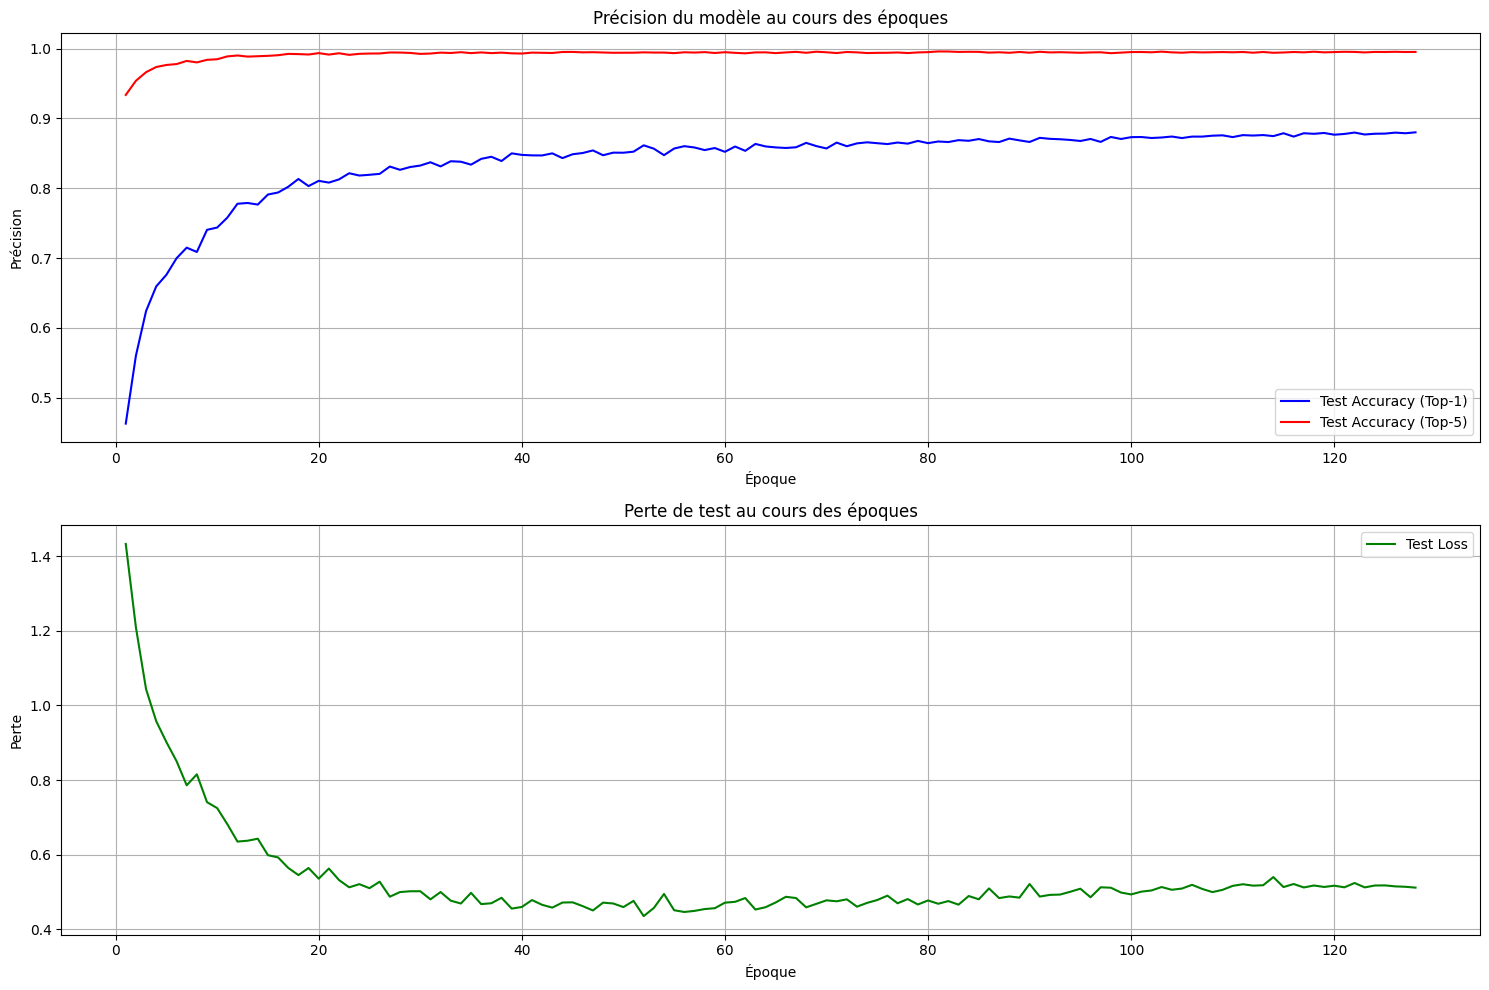

Meilleure précision: 0.8801 à l'époque 128.0
Fichier log ./training_log.txt non trouvé. Essayez de rediriger la sortie du script d'entraînement vers un fichier.
Exemple: python train_script.py > training_log.txt


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os
import glob

def plot_learning_curves(record_path, name_suffix="_step2", top_k=5):
    """
    Visualise les courbes d'apprentissage à partir des fichiers .mat générés
    """
    # Recherche du fichier le plus récent
    pattern = os.path.join(record_path, f'Test_*{name_suffix}.mat')
    files = glob.glob(pattern)
    
    if not files:
        print(f"Aucun fichier trouvé avec le pattern: {pattern}")
        return
    
    # Charger le fichier le plus récent
    latest_file = max(files, key=os.path.getctime)
    print(f"Fichier chargé: {latest_file}")
    
    data = loadmat(latest_file)
    record_data = data['Record_data']
    
    # Extraire les données
    epochs = record_data[:, 0]
    test_top1 = record_data[:, 2]
    test_topk = record_data[:, 3]
    test_loss = record_data[:, 4]
    
    # Créer les graphiques
    plt.figure(figsize=(15, 10))
    
    # Précision Top-1 et Top-k
    plt.subplot(2, 1, 1)
    plt.plot(epochs, test_top1, 'b-', label=f'Test Accuracy (Top-1)')
    plt.plot(epochs, test_topk, 'r-', label=f'Test Accuracy (Top-{top_k})')
    plt.title('Précision du modèle au cours des époques')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.grid(True)
    plt.legend()
    
    # Perte de test
    plt.subplot(2, 1, 2)
    plt.plot(epochs, test_loss, 'g-', label='Test Loss')
    plt.title('Perte de test au cours des époques')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(record_path, f'learning_curves{name_suffix}.png'))
    plt.show()
    
    return max(test_top1), epochs[np.argmax(test_top1)]

def extract_training_history(log_file_path):
    """
    Extraire l'historique d'entraînement à partir d'un fichier log
    """
    epochs = []
    train_acc_top1 = []
    train_acc_topk = []
    train_losses = []
    test_acc_top1 = []
    test_acc_topk = []
    test_losses = []
    max_test_accs = []
    learning_rates = []
    
    with open(log_file_path, 'r') as f:
        for line in f:
            if line.startswith('epoch='):
                parts = line.strip().split(',')
                
                # Extraire l'époque
                epoch = int(parts[0].split('=')[1])
                epochs.append(epoch)
                
                # Extraire les métriques d'entraînement
                for part in parts:
                    part = part.strip()
                    if 'train_acc_top1=' in part:
                        train_acc_top1.append(float(part.split('=')[1]))
                    elif 'train_acc_top5=' in part:
                        train_acc_topk.append(float(part.split('=')[1]))
                    elif 'train_loss=' in part:
                        train_losses.append(float(part.split('=')[1]))
                    elif 'test_top1=' in part:
                        test_acc_top1.append(float(part.split('=')[1]))
                    elif 'test_top5=' in part:
                        test_acc_topk.append(float(part.split('=')[1]))
                    elif 'test_loss=' in part:
                        test_losses.append(float(part.split('=')[1]))
                    elif 'max_test_acc=' in part:
                        max_test_accs.append(float(part.split('=')[1]))
                    elif 'LR=' in part:
                        learning_rates.append(float(part.split('=')[1]))
    
    return {
        'epochs': epochs,
        'train_acc_top1': train_acc_top1,
        'train_acc_topk': train_acc_topk,
        'train_losses': train_losses,
        'test_acc_top1': test_acc_top1,
        'test_acc_topk': test_acc_topk,
        'test_losses': test_losses,
        'max_test_accs': max_test_accs,
        'learning_rates': learning_rates
    }

def plot_train_test_comparison(history, top_k=5, save_path=None):
    """
    Compare les métriques d'entraînement et de test
    """
    epochs = history['epochs']
    
    plt.figure(figsize=(15, 15))
    
    # Précision Top-1
    plt.subplot(3, 1, 1)
    plt.plot(epochs, history['train_acc_top1'], 'b-', label='Train Accuracy (Top-1)')
    plt.plot(epochs, history['test_acc_top1'], 'r-', label='Test Accuracy (Top-1)')
    plt.title('Précision Top-1 (Train vs Test)')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.grid(True)
    plt.legend()
    
    # Précision Top-k
    plt.subplot(3, 1, 2)
    plt.plot(epochs, history['train_acc_topk'], 'b-', label=f'Train Accuracy (Top-{top_k})')
    plt.plot(epochs, history['test_acc_topk'], 'r-', label=f'Test Accuracy (Top-{top_k})')
    plt.title(f'Précision Top-{top_k} (Train vs Test)')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.grid(True)
    plt.legend()
    
    # Perte
    plt.subplot(3, 1, 3)
    plt.plot(epochs, history['train_losses'], 'b-', label='Train Loss')
    plt.plot(epochs, history['test_losses'], 'r-', label='Test Loss')
    plt.title('Perte (Train vs Test)')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

def plot_learning_rate(history, save_path=None):
    """
    Visualise l'évolution du taux d'apprentissage
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history['epochs'], history['learning_rates'], 'b-')
    plt.title("Évolution du taux d'apprentissag")
    plt.xlabel('Époque')
    plt.ylabel("Taux d'apprentissage")
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

# Exemple d'utilisation
if __name__ == "__main__":
    # Configuration selon les paramètres fournis
    BEGIN_EPOCH = 0
    MAX_EPOCH = 128
    TOP_K = 5
    NAME_SUFFIX = "_step1"
    RECORD_PATH = './recorddata/'
    SAVEMODEL_PATH = './savemodels/'
    
    # 1. Visualiser à partir des fichiers .mat
    max_acc, best_epoch = plot_learning_curves(RECORD_PATH, NAME_SUFFIX, TOP_K)
    print(f"Meilleure précision: {max_acc:.4f} à l'époque {best_epoch}")
    
    # 2. Extraire et visualiser à partir d'un fichier log
    # Si vous avez redirigé la sortie de votre script d'entraînement vers un fichier log
    LOG_FILE = "./training_log.txt"  # Ajustez selon votre chemin
    
    # Vérifier si le fichier log existe
    if os.path.exists(LOG_FILE):
        # Extraire l'historique
        history = extract_training_history(LOG_FILE)
        
        # Visualiser la comparaison train/test
        plot_train_test_comparison(
            history,
            TOP_K,
            save_path=f"{RECORD_PATH}train_test_comparison{NAME_SUFFIX}.png"
        )
        
        # Tracer la courbe de la meilleure précision
        plt.figure(figsize=(10, 6))
        plt.plot(history['epochs'], history['max_test_accs'], 'r-', label='Max Test Accuracy')
        plt.title('Évolution de la meilleure précision')
        plt.xlabel('Époque')
        plt.ylabel('Précision maximale')
        plt.grid(True)
        plt.legend()
        plt.savefig(f"{RECORD_PATH}max_accuracy{NAME_SUFFIX}.png")
        plt.show()
        
        # Tracer l'évolution du taux d'apprentissage
        plot_learning_rate(history, save_path=f"{RECORD_PATH}learning_rate{NAME_SUFFIX}.png")
    else:
        print(f"Fichier log {LOG_FILE} non trouvé. Essayez de rediriger la sortie du script d'entraînement vers un fichier.")
        print(f"Exemple: python train_script.py > training_log.txt")

In [16]:
torch.cuda.is_available()

True

1. Traçage des courbes d'apprentissage...


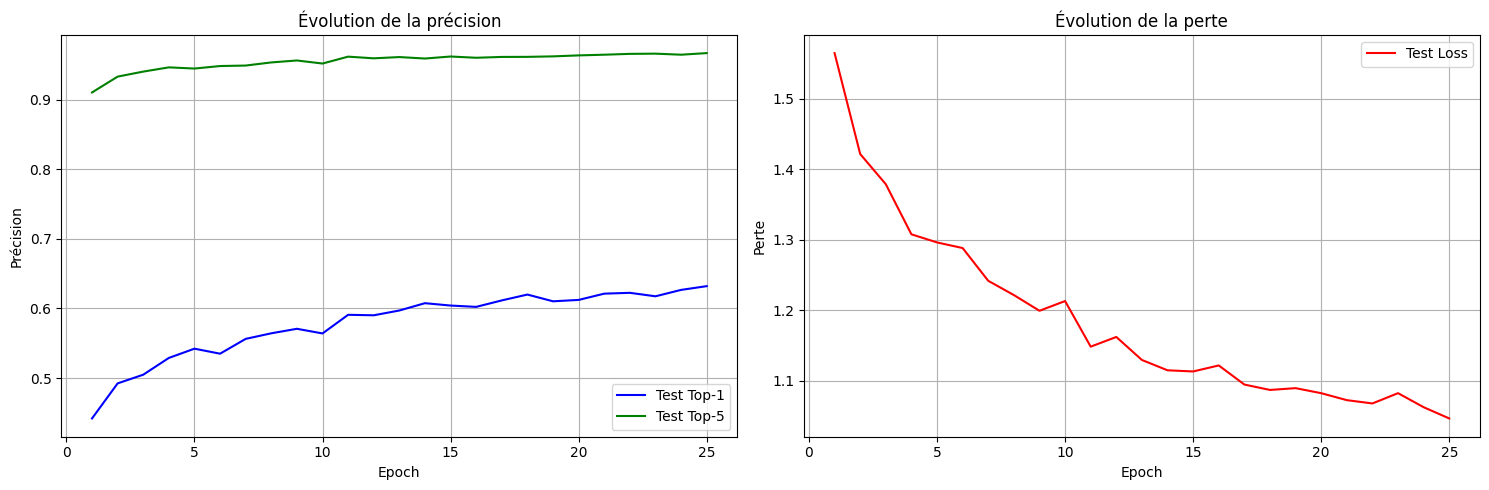

2. Calcul de la matrice de confusion...


100%|██████████| 40/40 [00:00<00:00, 51.70it/s]


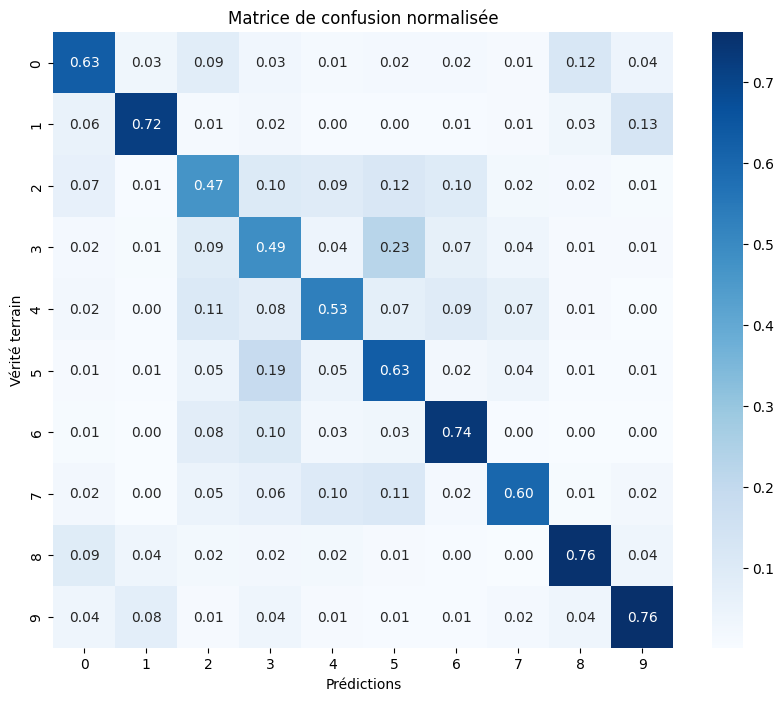

3. Analyse des poids binaires...
4. Évaluation de la sparsité des activations...


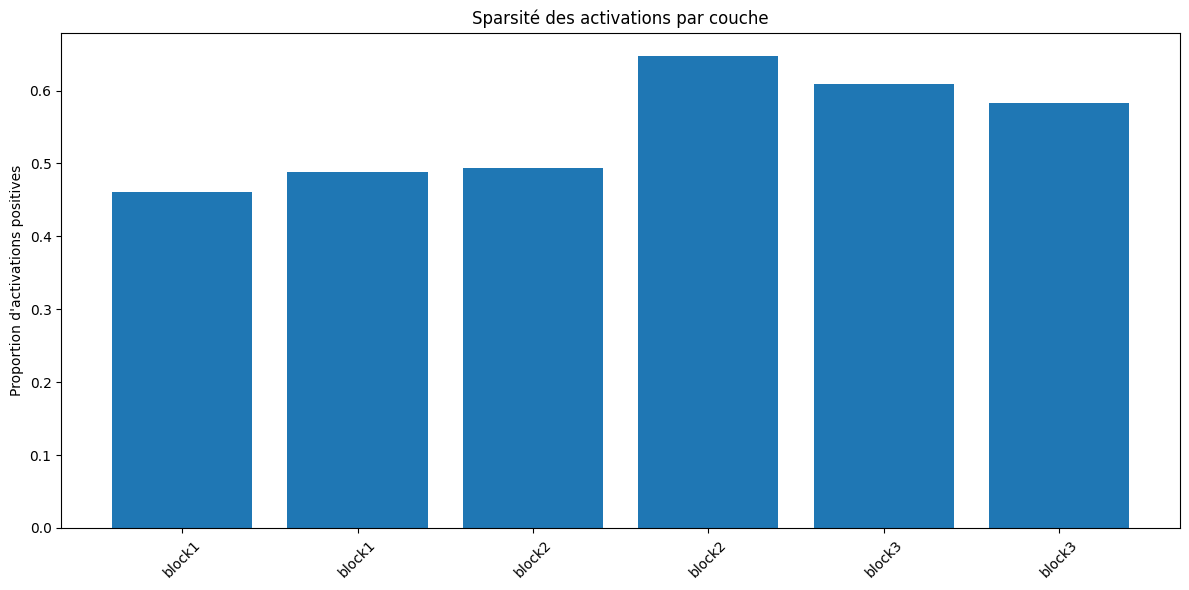


=== RÉSUMÉ DES RÉSULTATS ===
Précision finale (Top-1): 0.6321
Meilleure précision (Top-1): 0.6321 (epoch 25.0)
Précision finale (Top-5): 0.9671
Perte finale: 1.0469


# classic

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Définir le CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Paramètres
batch_size = 64
num_epochs = 50
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialiser le modèle, la perte et l'optimiseur
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Entraînement
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_data_loader):
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print(f'Époque [{epoch+1}/{num_epochs}], Perte: {running_loss/len(train_data_loader):.4f}')

# Test
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Précision sur le test: {100 * correct / total}%')

Époque [1/50], Perte: 1.7294
Époque [2/50], Perte: 1.4335
Époque [3/50], Perte: 1.3241
Époque [4/50], Perte: 1.2334
Époque [5/50], Perte: 1.1782
Époque [6/50], Perte: 1.1346
Époque [7/50], Perte: 1.0961
Époque [8/50], Perte: 1.0699
Époque [9/50], Perte: 1.0432
Époque [10/50], Perte: 1.0216
Époque [11/50], Perte: 1.0083
Époque [12/50], Perte: 0.9889
Époque [13/50], Perte: 0.9729
Époque [14/50], Perte: 0.9563
Époque [15/50], Perte: 0.9457
Époque [16/50], Perte: 0.9308
Époque [17/50], Perte: 0.9266
Époque [18/50], Perte: 0.9162
Époque [19/50], Perte: 0.9021
Époque [20/50], Perte: 0.8944
Époque [21/50], Perte: 0.8867
Époque [22/50], Perte: 0.8759
Époque [23/50], Perte: 0.8738
Époque [24/50], Perte: 0.8685
Époque [25/50], Perte: 0.8544
Époque [26/50], Perte: 0.8513
Époque [27/50], Perte: 0.8457
Époque [28/50], Perte: 0.8357
Époque [29/50], Perte: 0.8362
Époque [30/50], Perte: 0.8323
Époque [31/50], Perte: 0.8175
Époque [32/50], Perte: 0.8153
Époque [33/50], Perte: 0.8171
Époque [34/50], Per

In [ ]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Linear-7                  [-1, 128]         262,272
              ReLU-8                  [-1, 128]               0
           Dropout-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
Total params: 268,650
Trainable params: 268,650
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.42
Params size (MB): 1.02
Estimated T

In [13]:
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ScaledStdConv2d-1           [-1, 64, 32, 32]           1,728
      firstconv3x3-2           [-1, 64, 32, 32]               0
     LearnableBias-3           [-1, 64, 32, 32]              64
  BinaryActivation-4           [-1, 64, 32, 32]               0
HardBinaryScaledStdConv2d-5           [-1, 64, 32, 32]          36,864
           Q_PReLU-6           [-1, 64, 32, 32]               0
   SimplifiedBlock-7           [-1, 64, 32, 32]               0
     LearnableBias-8           [-1, 64, 32, 32]              64
  BinaryActivation-9           [-1, 64, 32, 32]               0
HardBinaryScaledStdConv2d-10           [-1, 64, 16, 16]          36,864
        AvgPool2d-11           [-1, 64, 16, 16]               0
          Q_PReLU-12           [-1, 64, 16, 16]               0
  SimplifiedBlock-13           [-1, 64, 16, 16]               0
    LearnableBias-14    